# Clustering - Split Dataset by sentence length
**Task**: Take a clustering dataset, split it into multiple datasets based on the length of the sentences and benchmark the performance of a clustering algorithm on each of the datasets.

In [1]:
%pip install python-dotenv datasets transformers scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
from dotenv import load_dotenv
if(load_dotenv(".env") == False):
    print("No .env file found")
from datasets import load_dataset
from transformers import AutoModel
import tqdm
import numpy as np
import sys
import os
import sklearn
import sklearn.cluster

# if path exists at all: "/Users/malte", add the mteb package to the path

if os.path.exists('/Users/malte'):
    sys.path.append('/Users/malte/Developer/embenchmark/packages/mteb')
    from packages.mteb.mteb.evaluation.evaluators import ClusteringEvaluator
else:
    from mteb import ClusteringEvaluator


# model = AutoModel.from_pretrained('jinaai/jina-embeddings-v2-base-en', trust_remote_code=True ).to('mps')
model = SentenceTransformer('')

In [3]:
model.encode("Lorem ipsum dolor sit amet, consectetur adipiscing elit. Aliquam hendrerit non libero at egestas. Nunc aliquam iaculis orci id lacinia. Nam ac urna congue, dapibus felis ut, condimentum leo. In libero metus, varius nec ultricies at, mattis eget ex. Nam tincidunt rhoncus pretium. Nam quis placerat felis. Donec convallis ante ac euismod pretium. Aliquam magna arcu, tempor et lorem ut, dictum posuere metus. Donec gravida aliquet laoreet. Sed ac massa dolor. Donec tincidunt sem in est ultrices fermentum. Sed in consequat ante, in faucibus urna. Donec iaculis bibendum ipsum, non dapibus urna consequat quis. Aenean eu fringilla libero. Nam egestas lorem leo, id varius risus ultricies id. Nulla in elit tellus. Aliquam hendrerit placerat fringilla. Pellentesque habitant morbi tristique senectus et netus et malesuada fames ac turpis egestas. Nulla facilisi. Integer egestas maximus mi non aliquet. Morbi et tempus urna. Integer volutpat dolor et lorem suscipit, ac ullamcorper ligula elementum. Proin accumsan, sapien sed euismod tempus, quam odio maximus dui, nec lacinia magna nisi vel erat. Donec odio justo, pretium in euismod eu, luctus sit amet nisl. Curabitur sollicitudin, dui vitae venenatis varius, odio sapien dictum arcu, et tincidunt metus eros vitae augue. Sed vel magna ut quam porta interdum. Sed vitae nibh lectus. Vivamus felis turpis, bibendum vel congue in, tristique a ante. Ut leo nisl, ultrices at porttitor eu, ullamcorper id sapien. Praesent molestie, nisl in condimentum auctor, mi sapien interdum odio, a mattis risus ligula nec mi. Fusce consequat ante lorem, id cursus libero facilisis in. Ut nec risus lorem. In pharetra justo eget odio placerat posuere. Nam vel nisl ipsum. Donec ut posuere tortor. Maecenas id enim blandit, pellentesque sem nec, tincidunt dolor. Aliquam consectetur mauris nec nisi volutpat luctus. Nunc tempus dui magna, quis porttitor quam ultrices vitae. Praesent eu mi blandit felis bibendum egestas sit amet non quam. Cras aliquam ultricies tortor id laoreet. Quisque risus augue, accumsan quis vulputate id, vestibulum et dolor. Praesent nulla purus, aliquet vitae orci sit amet, consequat auctor turpis. Duis rhoncus pharetra justo non vehicula. Integer vestibulum iaculis vestibulum. Donec condimentum, purus eu porta blandit, elit ante aliquam lectus, non ultricies felis dolor eu libero. Duis elementum massa quam, sit amet dignissim est malesuada dapibus.")

array([-3.28224272e-01, -2.25861192e-01,  7.68644392e-01,  2.89305389e-01,
       -8.69723782e-02,  3.44936848e-02,  1.31829679e-01, -4.00960654e-01,
        8.21037531e-01,  5.30947685e-01, -2.93557078e-01, -3.56913507e-01,
       -3.13871861e-01,  4.35310364e-01, -2.39897579e-01,  7.03264832e-01,
       -3.18590045e-01,  3.89612287e-01,  2.71432132e-01, -4.44263190e-01,
       -4.64006513e-01, -5.17209589e-01, -5.75835466e-01, -6.02083579e-02,
        3.43666524e-01,  6.86448634e-01,  3.84453565e-01,  1.87769353e-01,
        1.68828383e-01,  5.26927471e-01, -1.38831794e-01,  4.03478205e-01,
       -3.10320884e-01,  2.10948989e-01, -3.50877702e-01, -5.76881826e-01,
       -3.28562334e-02,  2.18825892e-01,  7.21675873e-01,  6.78117752e-01,
        3.10788900e-01,  1.31032988e-01,  1.62814651e-02,  1.06907332e+00,
       -2.67281920e-01,  1.65431350e-01, -2.30780542e-01, -2.73894779e-02,
       -1.04981318e-01, -4.30489898e-01, -3.76143038e-01, -7.55695581e-01,
       -2.73756627e-02, -

In [4]:
dataset = load_dataset("jinaai/cities_wiki_clustering")

In [19]:
def evaluator(sentences, labels, model, max_length=512, batch_size=1, clustering_batch_size=500):
    # cut sentences to max_length * 2 words to avoid OOM
    sentences = [s[:len(s.split()) * 2] for s in sentences]
    
    corpus_embeddings = np.asarray(model.encode(sentences, batch_size=batch_size, max_length=max_length))

    clustering_model = sklearn.cluster.MiniBatchKMeans(
        n_clusters=len(set(labels)), batch_size=clustering_batch_size, n_init="auto"
    )
    clustering_model.fit(corpus_embeddings)

    cluster_assignment = clustering_model.labels_

    v_measure = sklearn.metrics.cluster.v_measure_score(labels, cluster_assignment)

    return {"v_measure": v_measure}

In [20]:
def evaluate(model, dataset, max_length=512, split="test", **kwargs):
    v_measures = []
    for cluster_set in tqdm.tqdm(dataset[split], desc="Clustering"):
        metrics = evaluator(cluster_set["sentences"], cluster_set["labels"], model, max_length=max_length)
        v_measures.append(metrics["v_measure"])

    v_mean = np.mean(v_measures)
    v_std = np.std(v_measures)
    return {"v_measure": v_mean, "v_measure_std": v_std}

In [ ]:
dataset = load_dataset("text", data_files={"train": ["test.jsonl.gz"]})
# get keys of dataset["train"][0]
dataset["train"][0]['text']

# parse dataset["train"][0]['text'] json string
import json
decoded = json.loads(dataset["train"][0]['text'])

sentences, labels = decoded["sentences"], decoded["labels"]

# limit to 60 samples
sentences, labels = sentences[:60], labels[:60]

# split into three parts
n = len(sentences)
n1 = n // 3

sentences1, sentences2, sentences3 = sentences[:n1], sentences[n1:2*n1], sentences[2*n1:]
labels1, labels2, labels3 = labels[:n1], labels[n1:2*n1], labels[2*n1:]

ds = [{
    "sentences": sentences1,
    "labels": labels1
}, {
    "sentences": sentences2,
    "labels": labels2
}, {
    "sentences": sentences3,
    "labels": labels3
}]



# create new dataset from decoded



In [21]:
max_lengths = [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 8192]

for max_length in max_lengths:
  result = evaluate(model, dataset, max_length=max_length)
  print(max_length, result)
  # append line to file
  with open(f"results_max_length.txt", "a") as file:
    file.write(f"\"{max_length}\": {result},\n")

Clustering:   0%|          | 0/1 [00:17<?, ?it/s]


KeyboardInterrupt: 

In [5]:
bge_results = {
    "10": {"v_measure": 0.004265486331663628, "v_measure_std": 0.0},
    "20": {"v_measure": 0.014783134246078416, "v_measure_std": 0.0},
    "50": {"v_measure": 0.0653603311357436, "v_measure_std": 0.0},
    "100": {"v_measure": 0.12984256806534275, "v_measure_std": 0.0},
    "200": {"v_measure": 0.16736094418479605, "v_measure_std": 0.0},
    "500": {"v_measure": 0.21870875074933765, "v_measure_std": 0.0},
    "1000": {"v_measure": 0.21870875074933765, "v_measure_std": 0.0},
    "2000": {"v_measure": 0.218708750749337650, "v_measure_std": 0.0},
    "5000": {"v_measure": 0.21870875074933765, "v_measure_std": 0.0},
    "8192": {"v_measure":0.21870875074933765, "v_measure_std": 0.0},
}

jina_results = {
    "10": {"v_measure": 0.20267838077891376, "v_measure_std": 0.0},
    "20": {"v_measure": 0.237214610178106, "v_measure_std": 0.0},
    "50": {"v_measure": 0.27836851841068155, "v_measure_std": 0.0},
    "100": {"v_measure": 0.1867017971428439, "v_measure_std": 0.0},
    "200": {"v_measure": 0.3521228946014008, "v_measure_std": 0.0},
    "500": {"v_measure": 0.24973108569093466, "v_measure_std": 0.0},
    "10": {"v_measure": 0.0044920434783157085, "v_measure_std": 0.0},
    "20": {"v_measure": 0.005988463987034339, "v_measure_std": 0.0},
    "50": {"v_measure": 0.08207954056533083, "v_measure_std": 0.0},
    "100": {"v_measure": 0.11879162039782026, "v_measure_std": 0.0},
    "200": {"v_measure": 0.15729830446885912, "v_measure_std": 0.0},
    "500": {"v_measure": 0.2275371129887451, "v_measure_std": 0.0},
    "1000": {"v_measure": 0.2382059299783621, "v_measure_std": 0.0},
    "2000": {"v_measure": 0.2262169460580266, "v_measure_std": 0.0},
    "5000": {"v_measure": 0.23757748463911024, "v_measure_std": 0.0},
    "8192": {"v_measure": 0.23196095985211845, "v_measure_std": 0.0},
}

Split: 2000
2000 :  {'v_measure': 0.8144683159455076, 'v_measure_std': 0.0}
Split: 5000
5000 :  {'v_measure': 0.8143484186457459, 'v_measure_std': 0.0}
Split: 10000
10000 :  {'v_measure': 0.8205899050814626, 'v_measure_std': 0.0}
Split: 20000
20000 :  {'v_measure': 0.7590519167416516, 'v_measure_std': 0.0}


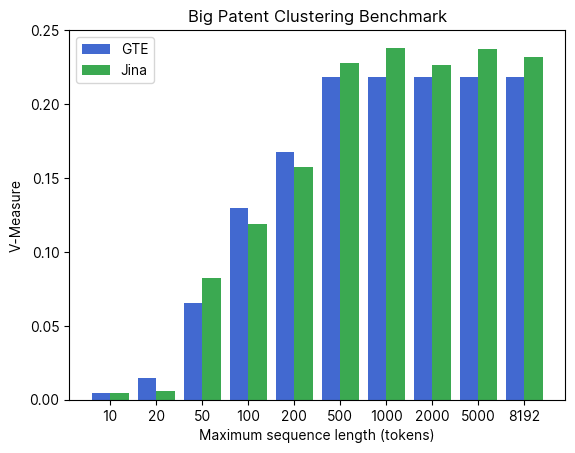

In [6]:
# plot results
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Inter"
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", [ "#4269D0","#3BA951", "#EFB117", "#FF725C"])


# plot gte and jina results in one plot
fig, ax = plt.subplots()

x = np.arange(len(jina_results))

rects1 = ax.bar(x - 0.2, [bge_results[str(split)]["v_measure"] for split in bge_results], 0.4, label='GTE')
rects2 = ax.bar(x + 0.2, [jina_results[str(split)]["v_measure"] for split in jina_results], 0.4, label='Jina')

ax.set_ylabel('V-Measure')
ax.set_xlabel('Maximum sequence length (tokens)')

ax.set_xticks(x)
ax.set_xticklabels(jina_results.keys())

# add title
ax.set_title('Big Patent Clustering Benchmark')

ax.legend()
plt.savefig('./results/clustering/big_patent_cutoff.png', dpi=300)
plt.show()